In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = datasets.Flowers102(root='flowers', split='train', transform=transform, download=True)
test_dataset = datasets.Flowers102(root='flowers', split='test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)


100%|██████████| 345M/345M [00:17<00:00, 19.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.66MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 13.0MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")


Device being used: cuda


In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [5/50], Loss: 0.0781
Epoch [10/50], Loss: 0.0357
Epoch [15/50], Loss: 0.0197
Epoch [20/50], Loss: 0.0157
Epoch [25/50], Loss: 0.0145
Epoch [30/50], Loss: 0.0136
Epoch [35/50], Loss: 0.0124
Epoch [40/50], Loss: 0.0106
Epoch [45/50], Loss: 0.0093
Epoch [50/50], Loss: 0.0085


<Figure size 1600x1200 with 0 Axes>

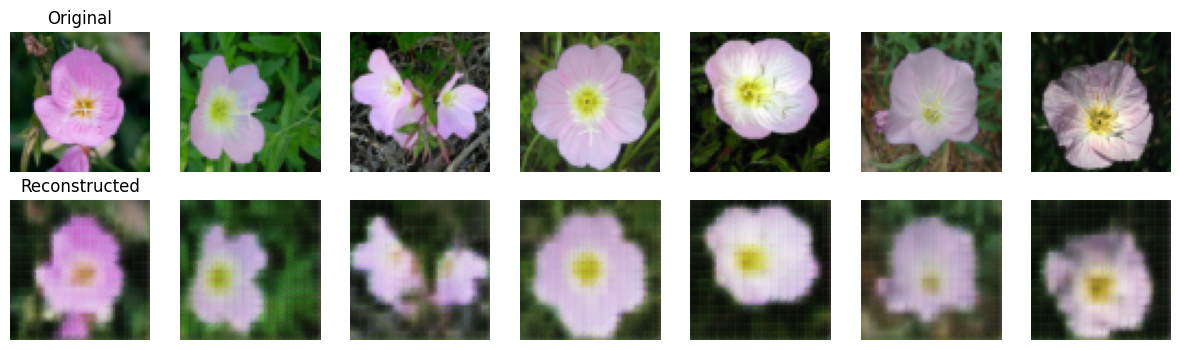

In [ ]:
torch.save(model.state_dict(), 'conv_autoencoder.pth')

model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('off')
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].axis('off')
ax[0, 0].set_title('Original')
ax[1, 0].set_title('Reconstructed')
plt.show()
